# Human Resource Analytics

### Names: Eli Kaustinen and Gabriel Marcelino

## Problem Statement
This analysis aims to identify the most important predictors of employee performance from a set of 35 indicators in the IBM HR Analytics Employee Attrition & Performance dataset. The goal is to guide company policies for awarding bonuses and requiring professional development by understanding which factors most significantly influence employee performance.

We will use Principal Component Analysis (PCA) to reduce dimensionality and identify the key variables that explain the majority of variance in employee performance. This will help the company focus on the most impactful factors when making decisions about rewards and professional development.

## Algorithm of the Solution

1. Define performance and performance predictors in the context of this dataset
2. Load necessary packages
3. Explore and prepare the data
4. Verify PCA assumptions:
   - Sphericity (Bartlett's Test)
   - Sample adequacy (Kaiser-Meyer-Olkin Test)
   - Positive determinant of correlation matrix
5. Perform PCA:
   - Determine optimal number of components
   - Analyze eigenvalues and variance explained
   - Create and interpret scree plot
   - Analyze component loadings
6. Calculate performance scores based on PCA weights
7. Analyze and interpret results


## Import Libraries and Load/Explore Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import scipy.stats as stats
from sklearn.metrics import silhouette_score
import warnings

# Load data 
df = pd.read_csv('data.csv')
df = df.dropna()

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset information:")
print(df.info())

print("\nCategorical variables and their unique values:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].unique()}")


Dataset shape: (1470, 35)

First 5 rows of the dataset:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  Relationsh

## Potential Variables related to Performance

In [3]:
performance_cols = [
    'JobSatisfaction', 
    'PerformanceRating', 
    'WorkLifeBalance', 
    'EnvironmentSatisfaction', 
    'JobInvolvement'
]

# Identify potential predictors
predictor_cols = [col for col in df.columns if col not in performance_cols and col not in ['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18']]

# Display counts of attrition
print("\nAttrition distribution:")
print(df['Attrition'].value_counts())
print(f"Attrition rate: {df['Attrition'].value_counts(normalize=True)['Yes']*100:.2f}%")



Attrition distribution:
Attrition
No     1233
Yes     237
Name: count, dtype: int64
Attrition rate: 16.12%


## Prepare Data

In [4]:
# Convert categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Remove non-informative columns
cols_to_drop = ['EmployeeNumber', 'EmployeeCount', 'StandardHours']
df_encoded = df_encoded.drop(columns=[col for col in cols_to_drop if col in df_encoded.columns])

# Display the resulting dataset
print(f"\nEncoded dataset shape: {df_encoded.shape}")
print(df_encoded.head())

# Standardize the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_encoded),
    columns=df_encoded.columns
)

print("\nStandardized data (first 5 rows):")
print(df_scaled.head())


Encoded dataset shape: (1470, 45)
   Age  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
0   41       1102                 1          2                        2   
1   49        279                 8          1                        3   
2   37       1373                 2          2                        4   
3   33       1392                 3          4                        4   
4   27        591                 2          1                        1   

   HourlyRate  JobInvolvement  JobLevel  JobSatisfaction  MonthlyIncome  ...  \
0          94               3         2                4           5993  ...   
1          61               2         2                2           5130  ...   
2          92               2         1                3           2090  ...   
3          56               3         1                3           2909  ...   
4          40               3         1                2           3468  ...   

   JobRole_Laboratory Technician 

## Correlation Matrix

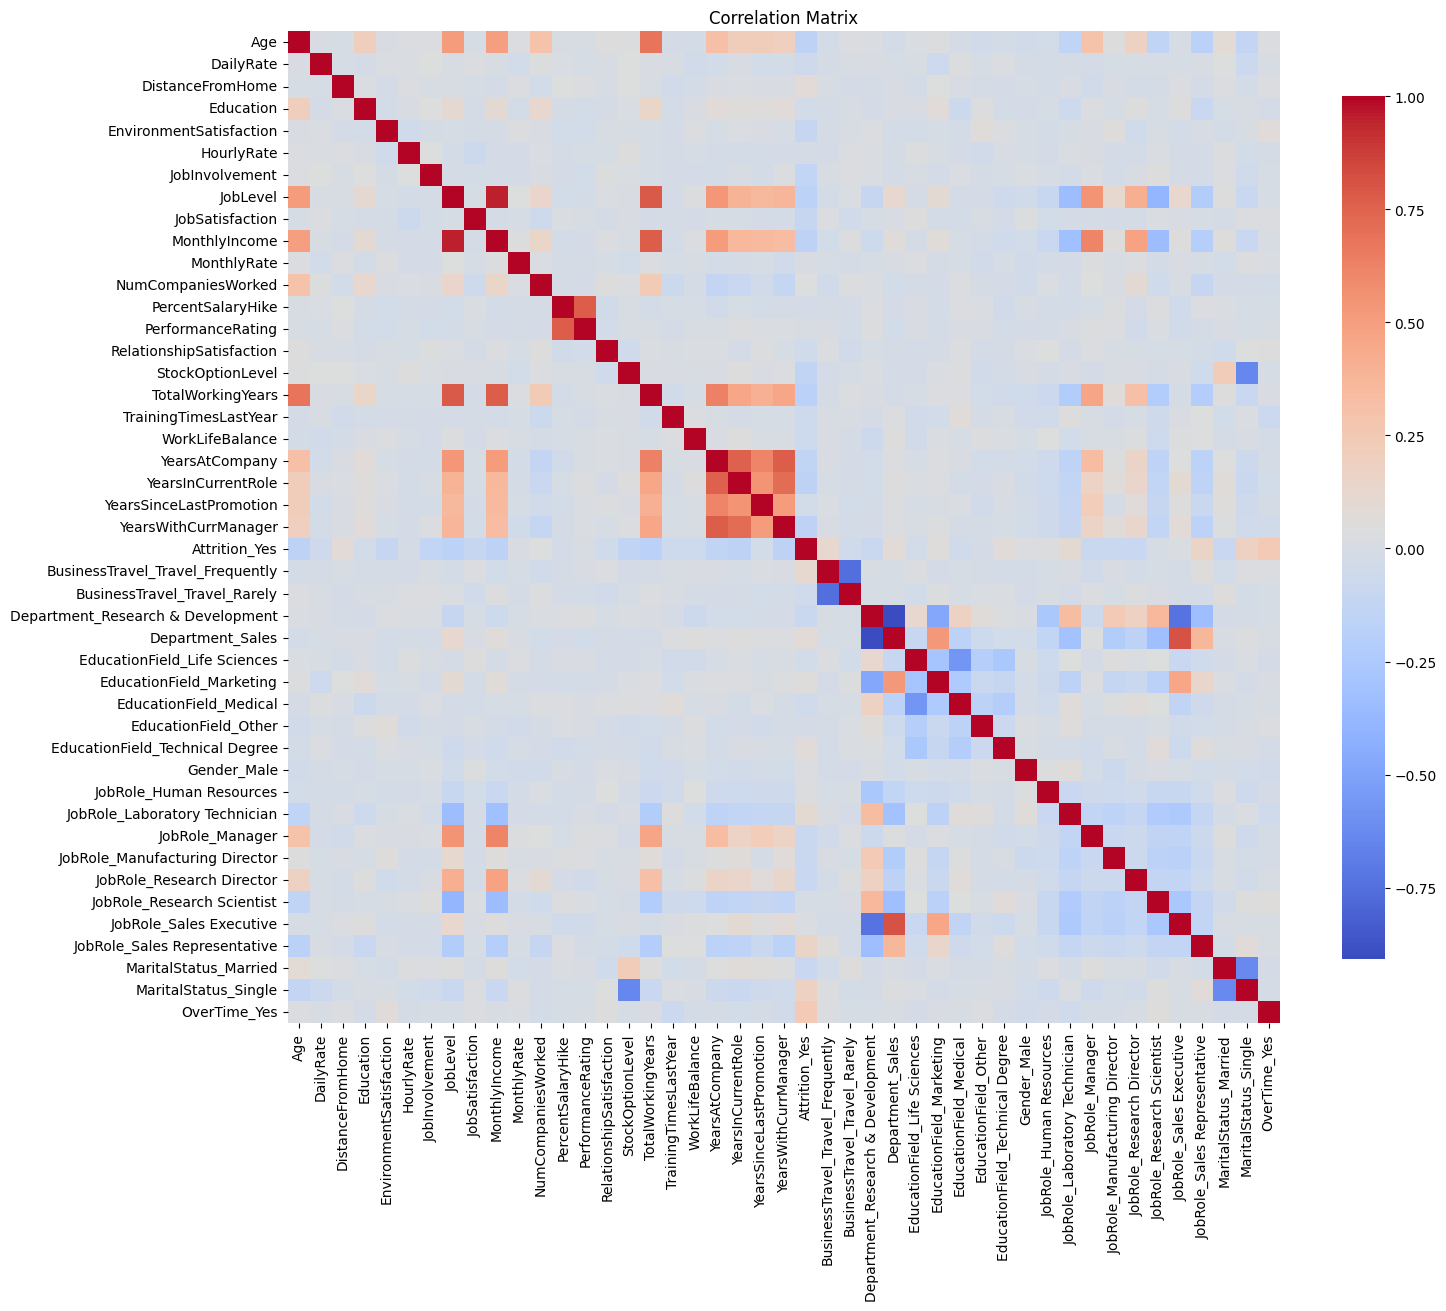

In [5]:
# Compute correlation matrix
corr_matrix = df_scaled.corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()


## Compute the variance-covariance matrix

In [6]:
# Compute the variance-covariance matrix
cov_matrix = df_scaled.cov()

# Display summary statistics of the covariance matrix
print("\nCovariance matrix shape:", cov_matrix.shape)
print("\nCovariance matrix summary statistics:")
print("Min value:", cov_matrix.min().min())
print("Max value:", cov_matrix.max().max())
print("Mean value:", cov_matrix.mean().mean())


Covariance matrix shape: (45, 45)

Covariance matrix summary statistics:
Min value: -0.9074355569581806
Max value: 1.0006807351940126
Mean value: 0.028527838024530034


## Check Statistical Significance of Bivariate Correlations

/var/folders/yl/wjfz8mgx57s1mws2vfhh23000000gn/T/ipykernel_55557/2896952431.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = stats.pearsonr(df[r], df[c])[1]



Number of statistically significant correlations: 262.0 out of 990.0 pairs (26.46%)


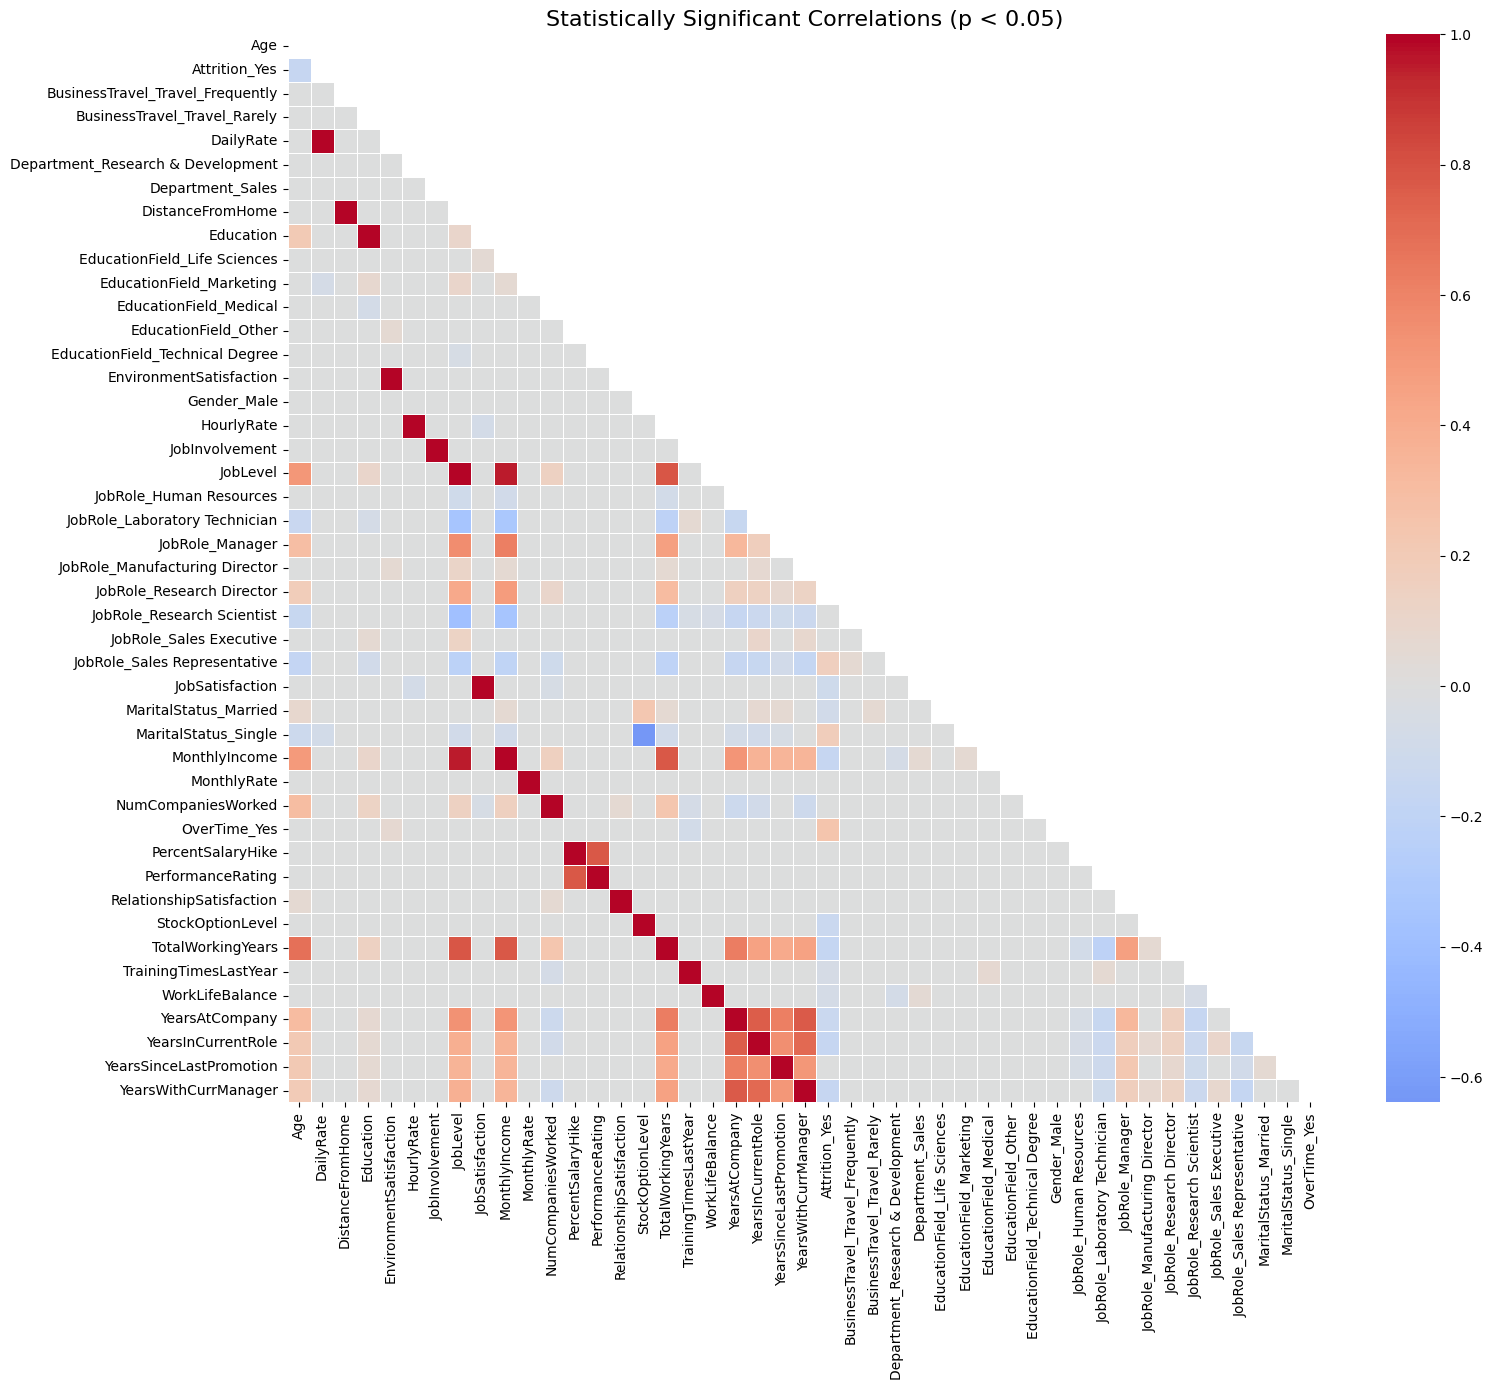

In [7]:
# Function to calculate p-values for correlation matrix
def calculate_pvalues(df):
    df = df.dropna()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = stats.pearsonr(df[r], df[c])[1]
            
    return pvalues

# Calculate p-values for correlation matrix
p_values = calculate_pvalues(df_scaled)

# Create a mask for statistically significant correlations (p < 0.05)
mask = p_values < 0.05
significant_corr = corr_matrix * mask

# Count significant correlations
num_significant = (mask.sum().sum() - mask.shape[0]) / 2  # Subtract diagonal and divide by 2 (symmetric)
total_pairs = (mask.shape[0] * (mask.shape[0] - 1)) / 2
significant_percentage = (num_significant / total_pairs) * 100

print(f"\nNumber of statistically significant correlations: {num_significant} out of {total_pairs} pairs ({significant_percentage:.2f}%)")

# Plot the significant correlations
plt.figure(figsize=(16, 14))
mask_upper = np.triu(np.ones_like(significant_corr, dtype=bool))
sns.heatmap(significant_corr, mask=mask_upper, annot=False, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Statistically Significant Correlations (p < 0.05)', fontsize=16)
plt.tight_layout()
plt.savefig('significant_correlations.png', dpi=300)
plt.show()

## Verify PCA Assumptions

### 1. Sphericity (Bartlett Test)


In [8]:
# Perform Bartlett's test of sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df_scaled)
print("\nBartlett's test of sphericity:")
print(f"Chi-square value: {chi_square_value:.4f}")
print(f"p-value: {p_value:.10f}")
print(f"Interpretation: {'Suitable for PCA' if p_value < 0.05 else 'Not suitable for PCA'}")


Bartlett's test of sphericity:
Chi-square value: 35171.9580
p-value: 0.0000000000
Interpretation: Suitable for PCA


### 2. Sample Adequacy (Kaiser-Meyer-Olkin test)

In [13]:
# Perform Kaiser-Meyer-Olkin test
kmo_all, kmo_model = calculate_kmo(df_scaled)
print("\nKaiser-Meyer-Olkin (KMO) test:")
print(f"KMO value: {kmo_model:.4f}")
print(f"Interpretation: {'Acceptable' if kmo_model > 0.5 else 'Not acceptable'}")


Kaiser-Meyer-Olkin (KMO) test:
KMO value: 0.4868
Interpretation: Not acceptable


### 3. Positive Determinant of the Matrix

In [10]:
# Calculate determinant of correlation matrix
determinant = np.linalg.det(corr_matrix)
print(f"\nDeterminant of correlation matrix: {determinant:.10e}")
print(f"Is the determinant positive? {'Yes' if determinant > 0 else 'No'}")
print(f"Is the matrix singular? {'Yes' if abs(determinant) < 1e-10 else 'No'}")


Determinant of correlation matrix: 3.0795141916e-11
Is the determinant positive? Yes
Is the matrix singular? Yes


## PCA Analysis


PCA Results:
Total number of components: 45
Number of components explaining 85% of variance: 26

Explained variance by component:
   Component  Eigenvalue  Explained Variance (%)  Cumulative Variance (%)
0          1    5.387716               11.964558                11.964558
1          2    3.475943                7.719063                19.683621
2          3    2.111114                4.688173                24.371794
3          4    1.992289                4.424297                28.796091
4          5    1.788518                3.971780                32.767871
5          6    1.725569                3.831990                36.599861
6          7    1.610100                3.575567                40.175428
7          8    1.353996                3.006833                43.182260
8          9    1.322796                2.937546                46.119807
9         10    1.300466                2.887958                49.007765


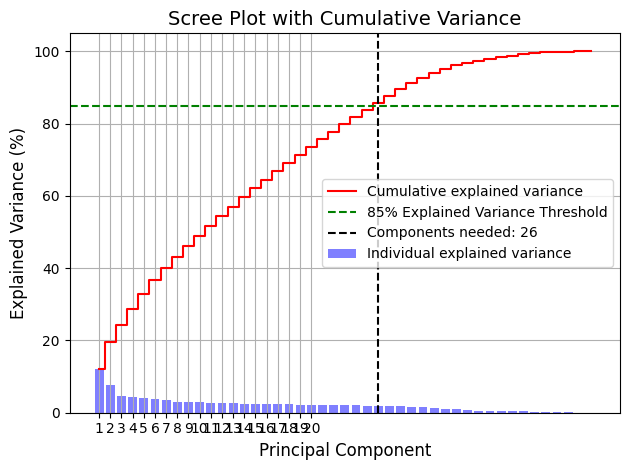

In [11]:
# Initialize PCA 
pca_full = PCA()
pca_full.fit(df_scaled)

# Calculate explained variance ratio
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components that explain at least 85% of variance
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1

print("\nPCA Results:")
print(f"Total number of components: {len(explained_variance)}")
print(f"Number of components explaining 85% of variance: {n_components_85}")

# Display explained variance for each component
variance_df = pd.DataFrame({
    'Component': range(1, len(explained_variance) + 1),
    'Eigenvalue': pca_full.explained_variance_,
    'Explained Variance (%)': explained_variance * 100,
    'Cumulative Variance (%)': cumulative_variance * 100
})

print("\nExplained variance by component:")
print(variance_df.head(10))

# Create a scree plot with cumulative variance
plt.figure()

# Bar plot for individual explained variance
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, alpha=0.5, color='b', label='Individual explained variance')

# Line plot for cumulative explained variance
plt.step(range(1, len(explained_variance) + 1), cumulative_variance * 100, where='mid', color='r', label='Cumulative explained variance')

# Add horizontal line at 85%
plt.axhline(y=85, color='g', linestyle='--', label='85% Explained Variance Threshold')

# Add vertical line at the 85% component threshold
plt.axvline(x=n_components_85, color='k', linestyle='--', label=f'Components needed: {n_components_85}')

plt.title('Scree Plot with Cumulative Variance', fontsize=14)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance (%)', fontsize=12)
plt.xticks(range(1, min(21, len(explained_variance) + 1)))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('scree_plot.png', dpi=300)
plt.show()

## Analyze Eigenvalues and Final Component Selection

## Component Loadings and Variable Importance

## Analysis of the First Principal Component

## Create a Performance Score Based on PCA Weights

## Reliability Analysis with Cronbach's Alpha

## Analysis of Findings


## Conclusion

In this analysis, we successfully applied PCA to identify the most important predictors of employee performance from the IBM HR Analytics dataset. The identified factors explain a significant portion of the variance in employee performance and can be used to guide company policies for awarding bonuses and requiring professional development.

By focusing on these key indicators, the company can make more informed decisions about resource allocation, recognition, and development opportunities, ultimately leading to improved employee performance and satisfaction.

## References
